# Simple AUTOENCODER for PETALO

Esta red la vamos a utilizar para obtener el radio 

In [1]:
import numpy as np
#np.random.seed(1337)  # for reproducibility
from time import time
from datetime import datetime
from sklearn import preprocessing
import sys
print(sys.path)
sys.path.append("/home/rgadea/lmfit-py/")
import seaborn as sns
from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D,BatchNormalization
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras.optimizers import SGD
from keras.utils import np_utils
from keras import regularizers
from math import floor
from lmfit.models import  GaussianModel
import matplotlib.pyplot as plt

['', '/home/rgadea3/anaconda3/envs/tensorflow/lib/python36.zip', '/home/rgadea3/anaconda3/envs/tensorflow/lib/python3.6', '/home/rgadea3/anaconda3/envs/tensorflow/lib/python3.6/lib-dynload', '/home/rgadea3/anaconda3/envs/tensorflow/lib/python3.6/site-packages', '/home/rgadea3/anaconda3/envs/tensorflow/lib/python3.6/site-packages/IPython/extensions', '/home/rgadea3/.ipython']


Using TensorFlow backend.


## Vamos introducir los datos de petalo preprocesados en pyhton


In [2]:
import scipy.io as sio
import hdf5storage
# datos_matlab = hdf5storage.loadmat('../datos_junio_2019/conjunto_entrenamiento_junio_2019_pitch7mm_rad165mm_29_total.mat')
npzfile = np.load('../conjuntos_datos_reconstruidos/fil5_pith7mm_rad165mm_scaled2_sig_sig_1200.npz')
npzfile.files

# conjunto_datos1= npzfile['arr_0']
# npzfile = np.load('../conjuntos_datos_reconstruidos/fil2_pith7mm_rad165mm_scaled2_sig_sig_1200.npz')
# npzfile.files

conjunto_datos= npzfile['arr_0']

# conjunto_datos=np.concatenate((conjunto_datos1,conjunto_datos2), axis=0)
print(conjunto_datos.shape)
# print(conjunto_datos[:10,6:26])

(50000, 3518)


## Network parameters:

In [3]:
batch_size = 1000
# aqui no aplicable porque es una regresion
# nb_classes = 10 

nb_epoch = 2000

n_hidden1=80
n_hidden2=60

# input image dimensions
img_rows, img_cols = 20, 31
# number of convolutional filters to use
nb_filters = 32
# size of pooling area for max pooling
pool_size = (2, 2)
# convolution kernel size
kernel_size = (4, 4)

## Prepare data into training and test set.

In [4]:
# the data, shuffled and split between train and test sets
# (X_train, y_train), (X_test, y_test) = mnist.load_data()
# conjunto_datos=photodefbox2_todo_e
numero_muestras=conjunto_datos.shape[0]
print(numero_muestras)
print('conjunto_datos shape:', conjunto_datos.shape)
maxInColumns = np.amax(conjunto_datos, axis=0)
print (maxInColumns[1])
# n, bins, patches = plt.hist(conjunto_datos[:,1], 400, normed=0, facecolor='green', alpha=0.75)


idea=conjunto_datos[:,6:3506]
veamos=idea.reshape(idea.shape[0],175, 20)
veamos2=np.zeros([idea.shape[0],20,175])
veamos2_3=np.zeros([idea.shape[0],20,525])
sector2=np.zeros([idea.shape[0],20,31])
veamos3=np.zeros([idea.shape[0],175])
# for i in range(idea.shape[0]):
for i in range(idea.shape[0]):
    veamos2[i]=np.reshape(veamos[i].transpose(), [20,175])
    veamos3[i]=np.sum(veamos2[i], axis=0)
    indice=np.argmax(veamos3[i], axis=0)
    veamos2_3[i]=np.concatenate((veamos2[i],veamos2[i],veamos2[i]),axis=1)   
    sector2[i]=veamos2_3[i,:,indice-15+175:indice+16+175]
    

print('sector shape:', sector2.shape)
conjunto_datos_nuevo=sector2.reshape(sector2.shape[0], img_rows*img_cols)
print('conjunto_datos_nuevo:', conjunto_datos_nuevo.shape)

print(idea[:10,:10])

50000
conjunto_datos shape: (50000, 3518)
194.99950513267174
sector shape: (50000, 20, 31)
conjunto_datos_nuevo: (50000, 620)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


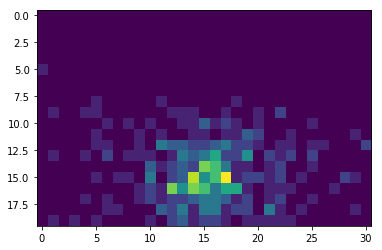

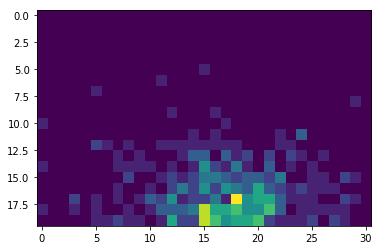

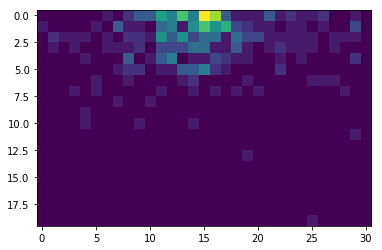

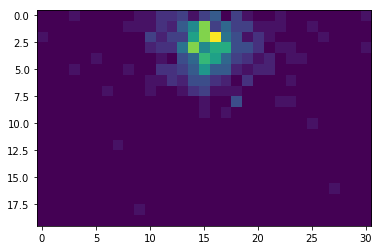

In [5]:
# convert class vectors to binary class matrices
#Y_train = np_utils.to_categorical(y_train, nb_classes)
#Y_test = np_utils.to_categorical(y_test, nb_classes)
for i in range(1,5):
    idea=np.random.randint(1,sector2.shape[0])
    plt.imshow(sector2[idea], cmap='viridis')
    plt.show()

In [6]:
tr_size=40
val_size=20
test_size=100-val_size-tr_size
conjunto_datos_nuevo2=np.concatenate((conjunto_datos[:,0:3],conjunto_datos_nuevo), axis=1)
tamanyo_tr=floor(tr_size*numero_muestras/100)
tamanyo_val=floor(val_size*numero_muestras/100)
tamanyo_test=numero_muestras-tamanyo_tr-tamanyo_val
print(tamanyo_tr)
print(tamanyo_val)
print(tamanyo_test)


XY_test=conjunto_datos_nuevo2[tamanyo_tr+tamanyo_val:numero_muestras,:]


XY_test_bin0=XY_test[np.where((XY_test[:,1]>=164.9999) * (XY_test[:,1]<171.000))]
XY_test_bin1=XY_test[np.where((XY_test[:,1]>=171.000) * (XY_test[:,1]<177.000))]
XY_test_bin2=XY_test[np.where((XY_test[:,1]>=177.000) * (XY_test[:,1]<183.0000))]
XY_test_bin3=XY_test[np.where((XY_test[:,1]>=183.000) * (XY_test[:,1]<189.0000))]
XY_test_bin4=XY_test[np.where((XY_test[:,1]>=189.0000))]

x_train=conjunto_datos_nuevo2[:tamanyo_tr,3:]
x_val=conjunto_datos_nuevo2[tamanyo_tr:tamanyo_tr+tamanyo_val,3:]
x_test=conjunto_datos_nuevo2[tamanyo_tr+tamanyo_val:numero_muestras,3:]

x_test_bin0=XY_test_bin0[:,3:]
Y_test_bin0=XY_test_bin0[:,1]
print(x_test_bin0.shape)
x_test_bin1=XY_test_bin1[:,3:]
Y_test_bin1=XY_test_bin1[:,1]
print(x_test_bin1.shape)
x_test_bin2=XY_test_bin2[:,3:]
Y_test_bin2=XY_test_bin2[:,1]
print(x_test_bin2.shape)
x_test_bin3=XY_test_bin3[:,3:]
Y_test_bin3=XY_test_bin3[:,1]
print(x_test_bin3.shape)
x_test_bin4=XY_test_bin4[:,3:]
Y_test_bin4=XY_test_bin4[:,1]
print(x_test_bin4.shape)



Y_train=conjunto_datos_nuevo2[:tamanyo_tr,1] #elijo la coordenada radius
Y_val=conjunto_datos_nuevo2[tamanyo_tr:tamanyo_tr+tamanyo_val,1] #elijo la corrdenada radius
Y_test=conjunto_datos_nuevo2[tamanyo_tr+tamanyo_val:numero_muestras,1] #elijo la corrdenada radius

20000
10000
20000
(8655, 620)
(3929, 620)
(2550, 620)
(2132, 620)
(2734, 620)


In [7]:
img_cols=31
img_rows=20

X_train = x_train.reshape(x_train.shape[0], img_rows, img_cols,1)
X_val = x_val.reshape(x_val.shape[0], img_rows, img_cols,1)
X_test = x_test.reshape(x_test.shape[0], img_rows, img_cols,1)

X_test_bin0 = x_test_bin0.reshape(x_test_bin0.shape[0], img_rows, img_cols,1)
X_test_bin1 = x_test_bin1.reshape(x_test_bin1.shape[0], img_rows, img_cols,1)
X_test_bin2 = x_test_bin2.reshape(x_test_bin2.shape[0], img_rows, img_cols,1)
X_test_bin3 = x_test_bin3.reshape(x_test_bin3.shape[0], img_rows, img_cols,1)
X_test_bin4 = x_test_bin4.reshape(x_test_bin4.shape[0], img_rows, img_cols,1)

input_shape = (img_rows, img_cols,1)
#input_shape=input_shape.astype('int32')

In [8]:
X_train = X_train.astype('float32')
X_val= X_val.astype('float32')
X_test = X_test.astype('float32')

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_val.shape[0], 'validation samples')
print(X_test.shape[0], 'test samples')

X_train shape: (20000, 20, 31, 1)
20000 train samples
10000 validation samples
20000 test samples


Display 20 random training images using image

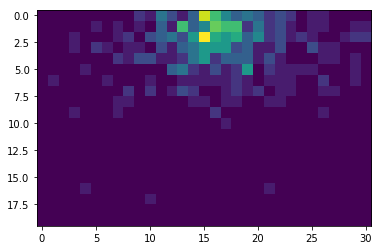

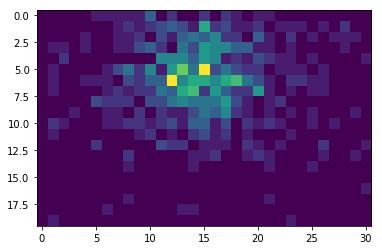

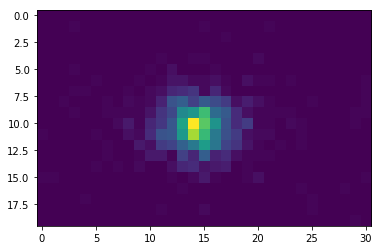

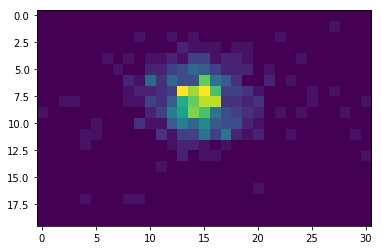

In [9]:
# convert class vectors to binary class matrices
#Y_train = np_utils.to_categorical(y_train, nb_classes)
#Y_test = np_utils.to_categorical(y_test, nb_classes)
for i in range(1,5):
    idea=np.random.randint(1,X_train.shape[0])
    plt.imshow(np.reshape(X_train[idea], [img_rows, img_cols]), cmap='viridis')
    plt.show()

## Build the MLP. 

In [10]:
print(x_val[:10,:10])

min_max_scaler = preprocessing.MinMaxScaler().fit(x_train)
#min_max_scaler = preprocessing.RobustScaler().fit(x_train)
# supermax=1
# factor_aprendizaje=0.0001
print(min_max_scaler)
# comentar las siguientes lineas si no queremos normalizar
# x_train = min_max_scaler.transform(x_train)
# x_val = min_max_scaler.transform(x_val)
# x_test = min_max_scaler.transform(x_test)
# x_test_bin0 = min_max_scaler.transform(x_test_bin0)
# x_test_bin1 = min_max_scaler.transform(x_test_bin1)
# x_test_bin2 = min_max_scaler.transform(x_test_bin2)
# x_test_bin3 = min_max_scaler.transform(x_test_bin3)
# x_test_bin4 = min_max_scaler.transform(x_test_bin4)
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_val.shape[0], 'validation samples')
print(X_test.shape[0], 'test samples')

model=Sequential()
# add input layer
model.add(Dense(
    units=n_hidden1,
    input_dim=x_train.shape[1],
    kernel_initializer='glorot_uniform',
    bias_initializer='zeros',
    activation='tanh') 
)
# add hidden layer
model.add(
    Dense(
        units=n_hidden1,
        input_dim=n_hidden2,
        kernel_initializer='glorot_uniform',
        bias_initializer='zeros',
        activation='tanh')
    )
# add output layer
model.add(
    Dense(
        units=1,
        input_dim=n_hidden2,
        kernel_initializer='glorot_uniform',
        bias_initializer='zeros',
        activation='linear')
    )

# define SGD optimizer
sgd_optimizer = SGD(
    lr=0.001, decay=1e-7, momentum=0.9
)
# compile model
experimento="{}_{}_tanh_tanh_linear_sin_normalizar_original_fil5".format(n_hidden1,n_hidden2)
algoritmo='adam'
tensorboard=TensorBoard(log_dir="/home/rgadea3/EXPERIMENTOS/nuevas_investigaciones_2018/experimentos/logs/defs/{}{}{}".format(experimento,algoritmo,datetime.now()))

model.compile(loss='mean_squared_error', optimizer=algoritmo

             )
print(x_val[:10,:10])



[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 2. 1. 0. 0. 1. 1. 2. 2. 3.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 1. 3. 1. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
MinMaxScaler(copy=True, feature_range=(0, 1))
X_train shape: (20000, 20, 31, 1)
20000 train samples
10000 validation samples
20000 test samples
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 2. 1. 0. 0. 1. 1. 2. 2. 3.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 1. 3. 1. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


Show a summary of the model parameters. 

In [11]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                49680     
_________________________________________________________________
dense_2 (Dense)              (None, 80)                6480      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 81        
Total params: 56,241
Trainable params: 56,241
Non-trainable params: 0
_________________________________________________________________


And now train the model and evaluate on the test set. 

In [12]:
early_stop=EarlyStopping(monitor='val_loss', min_delta=0, patience=500, verbose=2, mode='auto', baseline=None)
history = model.fit(x_train, Y_train, batch_size=batch_size, epochs=nb_epoch,
          verbose=1, validation_data=(x_val, Y_val),
          callbacks=[tensorboard,early_stop])

Train on 20000 samples, validate on 10000 samples
Epoch 1/2000
20000/20000 [==============================] - 3s 129us/step - loss: 28885.5120 - val_loss: 27605.1182
Epoch 2/2000
20000/20000 [==============================] - 0s 16us/step - loss: 26907.4034 - val_loss: 26423.6744
Epoch 3/2000
20000/20000 [==============================] - 0s 16us/step - loss: 26001.4469 - val_loss: 25687.4365
Epoch 4/2000
20000/20000 [==============================] - 0s 16us/step - loss: 25333.9652 - val_loss: 25061.6559
Epoch 5/2000
20000/20000 [==============================] - 0s 16us/step - loss: 24738.5932 - val_loss: 24486.7326
Epoch 6/2000
20000/20000 [==============================] - 0s 16us/step - loss: 24180.5471 - val_loss: 23941.2510
Epoch 7/2000
20000/20000 [==============================] - 0s 16us/step - loss: 23645.3798 - val_loss: 23414.9768
Epoch 8/2000
20000/20000 [==============================] - 0s 19us/step - loss: 23127.8307 - val_loss: 22904.8434
Epoch 9/2000
20000/20000 [===

20000/20000 [==============================] - 0s 16us/step - loss: 4655.4416 - val_loss: 4600.8585
Epoch 72/2000
20000/20000 [==============================] - 0s 16us/step - loss: 4513.4013 - val_loss: 4460.2625
Epoch 73/2000
20000/20000 [==============================] - 0s 16us/step - loss: 4374.7016 - val_loss: 4323.0430
Epoch 74/2000
20000/20000 [==============================] - 0s 16us/step - loss: 4239.3192 - val_loss: 4189.1324
Epoch 75/2000
20000/20000 [==============================] - 0s 16us/step - loss: 4107.2065 - val_loss: 4058.4547
Epoch 76/2000
20000/20000 [==============================] - 0s 16us/step - loss: 3978.3250 - val_loss: 3930.9144
Epoch 77/2000
20000/20000 [==============================] - 0s 16us/step - loss: 3852.5670 - val_loss: 3806.5300
Epoch 78/2000
20000/20000 [==============================] - 0s 16us/step - loss: 3729.9112 - val_loss: 3685.2579
Epoch 79/2000
20000/20000 [==============================] - 0s 16us/step - loss: 3610.3352 - val_loss

20000/20000 [==============================] - 0s 16us/step - loss: 280.6425 - val_loss: 280.6260
Epoch 144/2000
20000/20000 [==============================] - 0s 16us/step - loss: 269.0532 - val_loss: 269.2144
Epoch 145/2000
20000/20000 [==============================] - 0s 16us/step - loss: 258.0310 - val_loss: 258.3627
Epoch 146/2000
20000/20000 [==============================] - 0s 16us/step - loss: 247.5477 - val_loss: 248.0739
Epoch 147/2000
20000/20000 [==============================] - 0s 16us/step - loss: 237.6142 - val_loss: 238.2876
Epoch 148/2000
20000/20000 [==============================] - 0s 16us/step - loss: 228.1730 - val_loss: 229.0144
Epoch 149/2000
20000/20000 [==============================] - 0s 16us/step - loss: 219.2219 - val_loss: 220.2303
Epoch 150/2000
20000/20000 [==============================] - 0s 16us/step - loss: 210.7550 - val_loss: 211.8838
Epoch 151/2000
20000/20000 [==============================] - 0s 16us/step - loss: 202.7252 - val_loss: 203.981

20000/20000 [==============================] - 0s 14us/step - loss: 83.2876 - val_loss: 85.8163
Epoch 217/2000
20000/20000 [==============================] - 0s 13us/step - loss: 83.2524 - val_loss: 85.7765
Epoch 218/2000
20000/20000 [==============================] - 0s 15us/step - loss: 83.2221 - val_loss: 85.7405
Epoch 219/2000
20000/20000 [==============================] - 0s 16us/step - loss: 83.1958 - val_loss: 85.7066
Epoch 220/2000
20000/20000 [==============================] - 0s 16us/step - loss: 83.1725 - val_loss: 85.6751
Epoch 221/2000
20000/20000 [==============================] - 0s 16us/step - loss: 83.1519 - val_loss: 85.6467
Epoch 222/2000
20000/20000 [==============================] - 0s 16us/step - loss: 83.1314 - val_loss: 85.6257
Epoch 223/2000
20000/20000 [==============================] - 0s 16us/step - loss: 83.1166 - val_loss: 85.6033
Epoch 224/2000
20000/20000 [==============================] - 0s 16us/step - loss: 83.1011 - val_loss: 85.5864
Epoch 225/2000
2

Epoch 290/2000
20000/20000 [==============================] - 0s 16us/step - loss: 83.0034 - val_loss: 85.4121
Epoch 291/2000
20000/20000 [==============================] - 0s 14us/step - loss: 83.0038 - val_loss: 85.4113
Epoch 292/2000
20000/20000 [==============================] - 0s 15us/step - loss: 83.0034 - val_loss: 85.4112
Epoch 293/2000
20000/20000 [==============================] - 0s 16us/step - loss: 83.0039 - val_loss: 85.4122
Epoch 294/2000
20000/20000 [==============================] - 0s 15us/step - loss: 83.0035 - val_loss: 85.4114
Epoch 295/2000
20000/20000 [==============================] - 0s 16us/step - loss: 83.0035 - val_loss: 85.4109
Epoch 296/2000
20000/20000 [==============================] - 0s 16us/step - loss: 83.0036 - val_loss: 85.4107
Epoch 297/2000
20000/20000 [==============================] - 0s 16us/step - loss: 83.0031 - val_loss: 85.4114
Epoch 298/2000
20000/20000 [==============================] - 0s 16us/step - loss: 83.0035 - val_loss: 85.4126
E

Epoch 364/2000
20000/20000 [==============================] - 0s 16us/step - loss: 82.9967 - val_loss: 85.4107
Epoch 365/2000
20000/20000 [==============================] - 0s 16us/step - loss: 82.9967 - val_loss: 85.4127
Epoch 366/2000
20000/20000 [==============================] - 0s 16us/step - loss: 82.9961 - val_loss: 85.4115
Epoch 367/2000
20000/20000 [==============================] - 0s 16us/step - loss: 82.9958 - val_loss: 85.4145
Epoch 368/2000
20000/20000 [==============================] - 0s 16us/step - loss: 82.9942 - val_loss: 85.4114
Epoch 369/2000
20000/20000 [==============================] - 0s 16us/step - loss: 82.9924 - val_loss: 85.4124
Epoch 370/2000
20000/20000 [==============================] - 0s 16us/step - loss: 82.9928 - val_loss: 85.4139
Epoch 371/2000
20000/20000 [==============================] - 0s 16us/step - loss: 82.9924 - val_loss: 85.4140
Epoch 372/2000
20000/20000 [==============================] - 0s 16us/step - loss: 82.9923 - val_loss: 85.4126
E

20000/20000 [==============================] - 0s 16us/step - loss: 82.9864 - val_loss: 85.4100
Epoch 438/2000
20000/20000 [==============================] - 0s 16us/step - loss: 82.9842 - val_loss: 85.4158
Epoch 439/2000
20000/20000 [==============================] - 0s 15us/step - loss: 82.9811 - val_loss: 85.4121
Epoch 440/2000
20000/20000 [==============================] - 0s 16us/step - loss: 82.9812 - val_loss: 85.4129
Epoch 441/2000
20000/20000 [==============================] - 0s 16us/step - loss: 82.9814 - val_loss: 85.4117
Epoch 442/2000
20000/20000 [==============================] - 0s 16us/step - loss: 82.9831 - val_loss: 85.4098
Epoch 443/2000
20000/20000 [==============================] - 0s 16us/step - loss: 82.9807 - val_loss: 85.4148
Epoch 444/2000
20000/20000 [==============================] - 0s 16us/step - loss: 82.9834 - val_loss: 85.4169
Epoch 445/2000
20000/20000 [==============================] - 0s 17us/step - loss: 82.9821 - val_loss: 85.4130
Epoch 446/2000
2

20000/20000 [==============================] - 0s 16us/step - loss: 1.0887 - val_loss: 1.6153
Epoch 512/2000
20000/20000 [==============================] - 0s 16us/step - loss: 1.0407 - val_loss: 1.5953
Epoch 513/2000
20000/20000 [==============================] - 0s 16us/step - loss: 1.0073 - val_loss: 1.5855
Epoch 514/2000
20000/20000 [==============================] - 0s 16us/step - loss: 0.9694 - val_loss: 1.5554
Epoch 515/2000
20000/20000 [==============================] - 0s 16us/step - loss: 0.9410 - val_loss: 1.5425
Epoch 516/2000
20000/20000 [==============================] - 0s 16us/step - loss: 0.9148 - val_loss: 1.5202
Epoch 517/2000
20000/20000 [==============================] - 0s 16us/step - loss: 0.8946 - val_loss: 1.5168
Epoch 518/2000
20000/20000 [==============================] - 0s 15us/step - loss: 0.8678 - val_loss: 1.4996
Epoch 519/2000
20000/20000 [==============================] - 0s 16us/step - loss: 0.8382 - val_loss: 1.5061
Epoch 520/2000
20000/20000 [======

20000/20000 [==============================] - 0s 16us/step - loss: 0.3260 - val_loss: 1.5928
Epoch 587/2000
20000/20000 [==============================] - 0s 16us/step - loss: 0.3253 - val_loss: 1.6191
Epoch 588/2000
20000/20000 [==============================] - 0s 16us/step - loss: 0.3251 - val_loss: 1.6114
Epoch 589/2000
20000/20000 [==============================] - 0s 16us/step - loss: 0.3187 - val_loss: 1.6327
Epoch 590/2000
20000/20000 [==============================] - 0s 16us/step - loss: 0.3196 - val_loss: 1.6337
Epoch 591/2000
20000/20000 [==============================] - 0s 16us/step - loss: 0.3164 - val_loss: 1.6337
Epoch 592/2000
20000/20000 [==============================] - 0s 16us/step - loss: 0.3178 - val_loss: 1.6347
Epoch 593/2000
20000/20000 [==============================] - 0s 16us/step - loss: 0.3113 - val_loss: 1.6625
Epoch 594/2000
20000/20000 [==============================] - 0s 13us/step - loss: 0.3101 - val_loss: 1.6510
Epoch 595/2000
20000/20000 [======

20000/20000 [==============================] - 0s 16us/step - loss: 0.2065 - val_loss: 1.9813
Epoch 662/2000
20000/20000 [==============================] - 0s 15us/step - loss: 0.2042 - val_loss: 1.9784
Epoch 663/2000
20000/20000 [==============================] - 0s 16us/step - loss: 0.2048 - val_loss: 1.9987
Epoch 664/2000
20000/20000 [==============================] - 0s 16us/step - loss: 0.2026 - val_loss: 1.9989
Epoch 665/2000
20000/20000 [==============================] - 0s 16us/step - loss: 0.2032 - val_loss: 2.0106
Epoch 666/2000
20000/20000 [==============================] - 0s 16us/step - loss: 0.2042 - val_loss: 2.0105
Epoch 667/2000
20000/20000 [==============================] - 0s 16us/step - loss: 0.2057 - val_loss: 2.0151
Epoch 668/2000
20000/20000 [==============================] - 0s 16us/step - loss: 0.2030 - val_loss: 2.0156
Epoch 669/2000
20000/20000 [==============================] - 0s 14us/step - loss: 0.2019 - val_loss: 2.0304
Epoch 670/2000
20000/20000 [======

20000/20000 [==============================] - 0s 16us/step - loss: 0.1605 - val_loss: 2.0767
Epoch 737/2000
20000/20000 [==============================] - 0s 16us/step - loss: 0.1603 - val_loss: 2.0934
Epoch 738/2000
20000/20000 [==============================] - 0s 16us/step - loss: 0.1594 - val_loss: 2.0834
Epoch 739/2000
20000/20000 [==============================] - 0s 15us/step - loss: 0.1594 - val_loss: 2.0893
Epoch 740/2000
20000/20000 [==============================] - 0s 16us/step - loss: 0.1602 - val_loss: 2.0684
Epoch 741/2000
20000/20000 [==============================] - 0s 16us/step - loss: 0.1598 - val_loss: 2.0841
Epoch 742/2000
20000/20000 [==============================] - 0s 15us/step - loss: 0.1599 - val_loss: 2.0828
Epoch 743/2000
20000/20000 [==============================] - 0s 16us/step - loss: 0.1669 - val_loss: 2.0750
Epoch 744/2000
20000/20000 [==============================] - 0s 16us/step - loss: 0.1658 - val_loss: 2.0828
Epoch 745/2000
20000/20000 [======

20000/20000 [==============================] - 0s 16us/step - loss: 0.1356 - val_loss: 2.0448
Epoch 812/2000
20000/20000 [==============================] - 0s 16us/step - loss: 0.1343 - val_loss: 2.0351
Epoch 813/2000
20000/20000 [==============================] - 0s 16us/step - loss: 0.1342 - val_loss: 2.0476
Epoch 814/2000
20000/20000 [==============================] - 0s 16us/step - loss: 0.1364 - val_loss: 2.0421
Epoch 815/2000
20000/20000 [==============================] - 0s 15us/step - loss: 0.1364 - val_loss: 2.0363
Epoch 816/2000
20000/20000 [==============================] - 0s 16us/step - loss: 0.1373 - val_loss: 2.0361
Epoch 817/2000
20000/20000 [==============================] - 0s 16us/step - loss: 0.1347 - val_loss: 2.0377
Epoch 818/2000
20000/20000 [==============================] - 0s 16us/step - loss: 0.1338 - val_loss: 2.0281
Epoch 819/2000
20000/20000 [==============================] - 0s 16us/step - loss: 0.1342 - val_loss: 2.0454
Epoch 820/2000
20000/20000 [======

20000/20000 [==============================] - 0s 16us/step - loss: 0.1215 - val_loss: 1.9899
Epoch 887/2000
20000/20000 [==============================] - 0s 16us/step - loss: 0.1198 - val_loss: 1.9767
Epoch 888/2000
20000/20000 [==============================] - 0s 16us/step - loss: 0.1193 - val_loss: 1.9869
Epoch 889/2000
20000/20000 [==============================] - 0s 16us/step - loss: 0.1204 - val_loss: 1.9906
Epoch 890/2000
20000/20000 [==============================] - 0s 16us/step - loss: 0.1266 - val_loss: 1.9784
Epoch 891/2000
20000/20000 [==============================] - 0s 16us/step - loss: 0.1243 - val_loss: 1.9748
Epoch 892/2000
20000/20000 [==============================] - 0s 16us/step - loss: 0.1215 - val_loss: 1.9798
Epoch 893/2000
20000/20000 [==============================] - 0s 16us/step - loss: 0.1191 - val_loss: 1.9789
Epoch 894/2000
20000/20000 [==============================] - 0s 16us/step - loss: 0.1206 - val_loss: 1.9952
Epoch 895/2000
20000/20000 [======

20000/20000 [==============================] - 0s 16us/step - loss: 0.1092 - val_loss: 2.1060
Epoch 962/2000
20000/20000 [==============================] - 0s 16us/step - loss: 0.1084 - val_loss: 2.1084
Epoch 963/2000
20000/20000 [==============================] - 0s 16us/step - loss: 0.1069 - val_loss: 2.1245
Epoch 964/2000
20000/20000 [==============================] - 0s 16us/step - loss: 0.1066 - val_loss: 2.1391
Epoch 965/2000
20000/20000 [==============================] - 0s 16us/step - loss: 0.1072 - val_loss: 2.1204
Epoch 966/2000
20000/20000 [==============================] - 0s 15us/step - loss: 0.1096 - val_loss: 2.1247
Epoch 967/2000
20000/20000 [==============================] - 0s 16us/step - loss: 0.1050 - val_loss: 2.0857
Epoch 968/2000
20000/20000 [==============================] - 0s 16us/step - loss: 0.1036 - val_loss: 2.0994
Epoch 969/2000
20000/20000 [==============================] - 0s 16us/step - loss: 0.1041 - val_loss: 2.1018
Epoch 970/2000
20000/20000 [======

Epoch 1036/2000
20000/20000 [==============================] - 0s 16us/step - loss: 0.0916 - val_loss: 2.0389
Epoch 1037/2000
20000/20000 [==============================] - 0s 16us/step - loss: 0.0904 - val_loss: 2.0259
Epoch 1038/2000
20000/20000 [==============================] - 0s 16us/step - loss: 0.0902 - val_loss: 2.0516
Epoch 1039/2000
20000/20000 [==============================] - 0s 16us/step - loss: 0.0886 - val_loss: 2.0418
Epoch 1040/2000
20000/20000 [==============================] - 0s 16us/step - loss: 0.0888 - val_loss: 2.0226
Epoch 1041/2000
20000/20000 [==============================] - 0s 16us/step - loss: 0.0894 - val_loss: 2.0321
Epoch 1042/2000
20000/20000 [==============================] - 0s 16us/step - loss: 0.0894 - val_loss: 2.0672
Epoch 1043/2000
20000/20000 [==============================] - 0s 15us/step - loss: 0.0907 - val_loss: 2.0429
Epoch 1044/2000
20000/20000 [==============================] - 0s 16us/step - loss: 0.0896 - val_loss: 2.0426
Epoch 1045

In [13]:
score = model.evaluate(x_test, Y_test, verbose=0)
print('Test mse:', score)
# print('Test mae:', score[1])
Y_test_predicted=model.predict(x_test)
x_test_array=np.asarray(Y_test)
print(x_test_array.shape)
error_prediction=Y_test-Y_test_predicted.flatten()
print(error_prediction.shape)
print(error_prediction[:10])
print(Y_test.shape)
print(Y_test_predicted.shape)

Test mse: 1.6425318989753723
(20000,)
(20000,)
[ 0.95002664  1.23109237 -0.38287052  0.71376599 -1.72783679  0.42551722
  0.08668747  3.77832088  0.05249884  1.34751165]
(20000,)
(20000, 1)


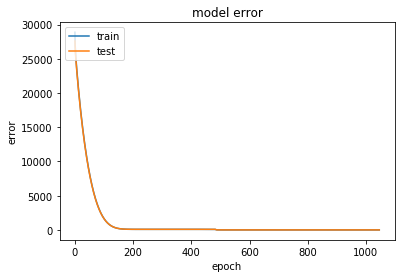

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model error')
plt.ylabel('error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [15]:
#print(error_prediction)

/home/rgadea3/anaconda3/envs/tensorflow/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


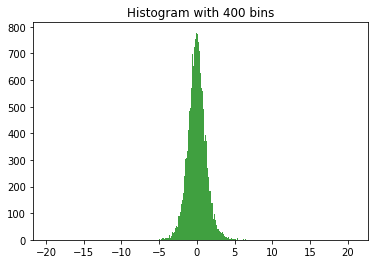

(400,)
(401,)
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 400
    # variables        = 3
    chi-square         = 44724.9983
    reduced chi-square = 112.657426
    Akaike info crit   = 1892.72933
    Bayesian info crit = 1904.70372
[[Variables]]
    amp:  738.576548 +/- 3.02697532 (0.41%) (init = 1000)
    cen: -0.08309576 +/- 0.00497075 (5.98%) (init = 0)
    wid:  1.48548765 +/- 0.00702970 (0.47%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, wid) = -0.577



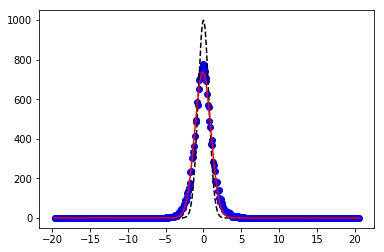

In [16]:

n, bins, patches = plt.hist(error_prediction, 400, normed=0, facecolor='green', alpha=0.75)
plt.title("Histogram with 400 bins")
plt.show()
x=bins[:400]
y=n
print(n.shape)
print(bins.shape)
from numpy import exp, loadtxt, pi, sqrt, log

from lmfit import Model
def gaussian(x, amp, cen, wid):
    """1-d gaussian: gaussian(x, amp, cen, wid)"""
    return amp * exp(-((x-cen)/wid)**2 )


gmodel = Model(gaussian)
result = gmodel.fit(y, x=x, amp=1000, cen=0, wid=1)

print(result.fit_report())

plt.plot(x, y, 'bo')
plt.plot(x, result.init_fit, 'k--')
plt.plot(x, result.best_fit, 'r-')
plt.show()





In [17]:
FWHM=result.params['wid'].value*2*sqrt(log(2))

In [18]:
print(FWHM)

2.4734991824949977


[[166.59288]
 [168.67853]
 [165.72136]
 ...
 [165.59842]
 [165.63261]
 [165.86102]]


/home/rgadea3/anaconda3/envs/tensorflow/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


2.8917422026346444


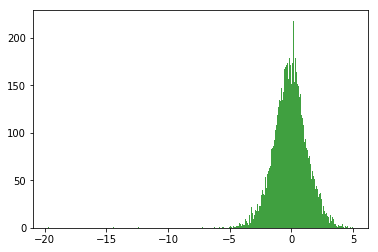

In [19]:
Y_test_bin0_predicted=model.predict(x_test_bin0)
print(Y_test_bin0_predicted)
error_prediction_bin0=Y_test_bin0-Y_test_bin0_predicted.flatten()
n, bins, patches = plt.hist(error_prediction_bin0, 400, normed=0, facecolor='green', alpha=0.75)

x=bins[:400]
y=n

gmodel = Model(gaussian)
result = gmodel.fit(y, x=x, amp=1000, cen=0, wid=1)
FWHM_bin0=result.params['wid'].value*2*sqrt(log(2))
print(FWHM_bin0)

/home/rgadea3/anaconda3/envs/tensorflow/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


2.7057386592603034


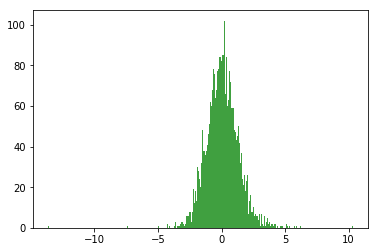

In [20]:
Y_test_bin1_predicted=model.predict(x_test_bin1)
#print(Y_test_bin1_predicted)
error_prediction_bin1=Y_test_bin1-Y_test_bin1_predicted.flatten()
n, bins, patches = plt.hist(error_prediction_bin1, 400, normed=0, facecolor='green', alpha=0.75)

x=bins[:400]
y=n

gmodel = Model(gaussian)
result = gmodel.fit(y, x=x, amp=1000, cen=0, wid=1)
FWHM_bin1=result.params['wid'].value*2*sqrt(log(2))
print(FWHM_bin1)

/home/rgadea3/anaconda3/envs/tensorflow/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


2.279496416098469


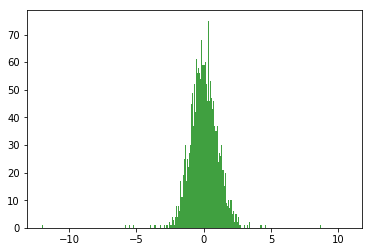

In [21]:
Y_test_bin2_predicted=model.predict(x_test_bin2)
#print(Y_test_bin2_predicted)
error_prediction_bin2=Y_test_bin2-Y_test_bin2_predicted.flatten()
n, bins, patches = plt.hist(error_prediction_bin2, 400, normed=0, facecolor='green', alpha=0.75)

x=bins[:400]
y=n

gmodel = Model(gaussian)
result = gmodel.fit(y, x=x, amp=1000, cen=0, wid=1)
FWHM_bin2=result.params['wid'].value*2*sqrt(log(2))
print(FWHM_bin2)

/home/rgadea3/anaconda3/envs/tensorflow/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


1.8225194349467602


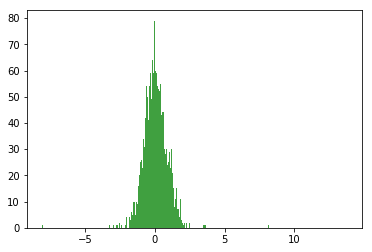

In [22]:
Y_test_bin3_predicted=model.predict(x_test_bin3)
#print(Y_test_bin3_predicted)
error_prediction_bin3=Y_test_bin3-Y_test_bin3_predicted.flatten()
n, bins, patches = plt.hist(error_prediction_bin3, 400, normed=0, facecolor='green', alpha=0.75)

x=bins[:400]
y=n

gmodel = Model(gaussian)
result = gmodel.fit(y, x=x, amp=1000, cen=0, wid=1)
FWHM_bin3=result.params['wid'].value*2*sqrt(log(2))
print(FWHM_bin3)

/home/rgadea3/anaconda3/envs/tensorflow/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


1.9932654218651418
1.8225194349467602
2.279496416098469
2.7057386592603034
2.8917422026346444


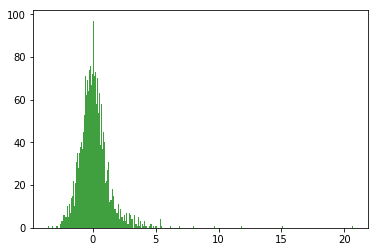

In [23]:
Y_test_bin4_predicted=model.predict(x_test_bin4)
#print(Y_test_bin4_predicted)
error_prediction_bin4=Y_test_bin4-Y_test_bin4_predicted.flatten()
n, bins, patches = plt.hist(error_prediction_bin4, 400, normed=0, facecolor='green', alpha=0.75)

x=bins[:400]
y=n

gmodel = Model(gaussian)
result = gmodel.fit(y, x=x, amp=1000, cen=0, wid=1)
FWHM_bin4=result.params['wid'].value*2*sqrt(log(2))
print(FWHM_bin4)
print(FWHM_bin3)
print(FWHM_bin2)
print(FWHM_bin1)
print(FWHM_bin0)